In [33]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

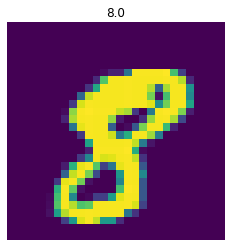

In [40]:
# Prepare Dataset
# load data
train = pd.read_csv("train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (features_numpy.shape[0] / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [66]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
           
    def forward(self, x):
        out = self.linear(x)
        return out

# Instantiate Model Class
input_dim = 28*28 # size of image px*px
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [69]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = (images.view(-1, 28*28))
        labels = (labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = (images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                
                # Total number of labels
                total += labels.shape[0]
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.6002342700958252  Accuracy: 74.35713958740234%
Iteration: 1000  Loss: 1.466158390045166  Accuracy: 77.95237731933594%
Iteration: 1500  Loss: 1.1795806884765625  Accuracy: 79.77381134033203%
Iteration: 2000  Loss: 1.1226928234100342  Accuracy: 81.0%
Iteration: 2500  Loss: 0.9695647358894348  Accuracy: 81.91666412353516%
Iteration: 3000  Loss: 0.8761752843856812  Accuracy: 82.58333587646484%
Iteration: 3500  Loss: 0.8542970418930054  Accuracy: 82.97618865966797%
Iteration: 4000  Loss: 0.7228477597236633  Accuracy: 83.27381134033203%
Iteration: 4500  Loss: 0.9372583031654358  Accuracy: 83.63095092773438%
Iteration: 5000  Loss: 0.7798659801483154  Accuracy: 83.95237731933594%
Iteration: 5500  Loss: 0.7258101105690002  Accuracy: 84.35713958740234%
Iteration: 6000  Loss: 0.8492602705955505  Accuracy: 84.61904907226562%
Iteration: 6500  Loss: 0.6439656019210815  Accuracy: 84.78571319580078%
Iteration: 7000  Loss: 0.6952494978904724  Accuracy: 85.07142639160156%
Iterati

Text(0.5, 1.0, 'LogisticRegression')

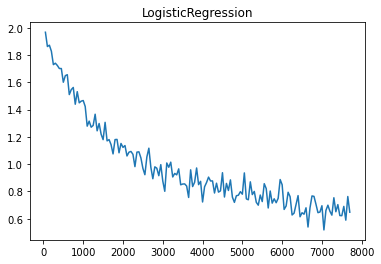

In [72]:
plt.plot(iteration_list,loss_list)
plt.title('LogisticRegression')

# ANN

In [144]:
class ANN(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim):
        super(ANN , self).__init__()
        
        # linear function
        self.fc1=nn.Linear(input_dim,hidden_dim)
        # non linear
        self.relu1=nn.ReLU()
        
        self.fc2=nn.Linear(hidden_dim,hidden_dim)
        self.tanh2=nn.Tanh()
        
        self.fc3=nn.Linear(hidden_dim,hidden_dim)
        self.elu3=nn.ELU()
        
        self.fc4=nn.Linear(hidden_dim,output_dim)
        
         
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANN(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [145]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        train=images.view(-1,28*28)
        optimizer.zero_grad()
        outputs=model(train)
        loss=error(outputs,labels)
        loss.backward()
        optimizer.step()
        count += 1
        if count % 50 == 0:
            total = 0
            correct = 0
            for images, labels in test_loader:
                test = images.view(-1,28*28)
                outputs = model(test)
                total += labels.shape[0]
                predicted = torch.max(outputs.data,1)[1]
                correct += (predicted == labels).sum()
            accuracy=100 * correct /float( total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            print('Iteration {}, loss {}, accuracy {}'.format(count,loss.data,accuracy))

Iteration 500, loss 0.7639983296394348, accuracy 77.94047546386719
Iteration 1000, loss 0.45432692766189575, accuracy 87.95237731933594
Iteration 1500, loss 0.23349100351333618, accuracy 89.70237731933594
Iteration 2000, loss 0.28745970129966736, accuracy 90.5
Iteration 2500, loss 0.31520164012908936, accuracy 91.77381134033203
Iteration 3000, loss 0.12291838973760605, accuracy 92.46428680419922
Iteration 3500, loss 0.22876682877540588, accuracy 93.29762268066406
Iteration 4000, loss 0.0634237751364708, accuracy 93.77381134033203
Iteration 4500, loss 0.3345476984977722, accuracy 94.3452377319336
Iteration 5000, loss 0.10705184936523438, accuracy 94.76190185546875
Iteration 5500, loss 0.17987754940986633, accuracy 94.8452377319336
Iteration 6000, loss 0.19507776200771332, accuracy 95.08333587646484
Iteration 6500, loss 0.08784569799900055, accuracy 95.44047546386719
Iteration 7000, loss 0.10759498924016953, accuracy 95.77381134033203
Iteration 7500, loss 0.12623533606529236, accuracy 95

Text(0.5, 1.0, 'Number of iteration loss error')

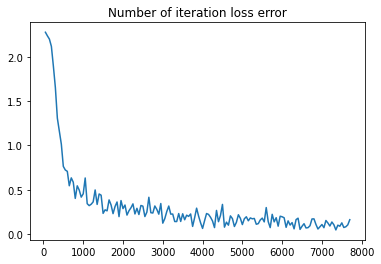

In [148]:
plt.plot(iteration_list,loss_list)
plt.title('Number of iteration loss error')

Text(0.5, 1.0, 'Number of iteration accuracy')

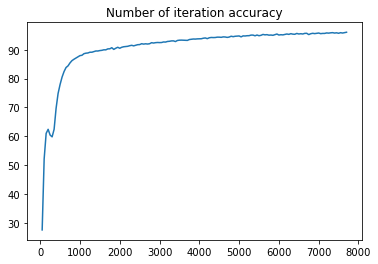

In [149]:
plt.plot(iteration_list,accuracy_list)
plt.title('Number of iteration accuracy')

# Convolutional Neural Network (CNN)

In [158]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(1,16,5)
        self.relu1=nn.ReLU()
        self.max_pool1=nn.MaxPool2d(2)
        
        self.conv2=nn.Conv2d(16,32,5)
        self.relu2=nn.ReLU()
        self.max_pool2=nn.MaxPool2d(2)
        
        
        self.linear2=nn.Linear(32*4*4,10)
        
    def forward(self,x):
        out= self.max_pool1(self.relu1(self.conv1(x)))
        out=self.max_pool2(self.relu2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out=self.linear2(out)
        return out

In [162]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [163]:
model = CNN()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [165]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        train=images.view(100,1,28,28)
        optimizer.zero_grad()
        outputs=model(train)
        loss=error(outputs,labels)
        loss.backward()
        optimizer.step()
        count += 1
        if count % 50 == 0:
            total = 0
            correct = 0
            for images, labels in test_loader:
                test = images.view(100,1,28,28)
                outputs = model(test)
                total += labels.shape[0]
                predicted = torch.max(outputs.data,1)[1]
                correct += (predicted == labels).sum()
            accuracy=100 * correct /float( total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            print('Iteration {}, loss {}, accuracy {}'.format(count,loss.data,accuracy))

Iteration 500, loss 0.02950107492506504, accuracy 98.20237731933594
Iteration 1000, loss 0.0339885838329792, accuracy 98.4047622680664
Iteration 1500, loss 0.007918233051896095, accuracy 98.1547622680664
Iteration 2000, loss 0.006634758785367012, accuracy 98.4047622680664
